In [1]:
### Loading Conda Colab ###
# https://github.com/conda-incubator/condacolab
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [2]:
### Importing PyGMT ###
!conda --version

!conda install pygmt
import pygmt

conda 23.11.0
Channels:
 - conda-forge
Platform: linux-64
Solving environment: \ | / - \ | done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.5.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.



In [3]:
pygmt.show_versions()

### Imports ###
import matplotlib.pyplot as plt
import numpy as np

!pip install ipympl
from PIL import Image
import matplotlib.image as mpimg # base image
!pip install basemap
from mpl_toolkits.basemap import Basemap

from google.colab import output
output.enable_custom_widget_manager()

PyGMT information:
  version: v0.12.0
System information:
  python: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
  executable: /usr/bin/python3.real
  machine: Linux-6.1.85+-x86_64-with-glibc2.35
Dependency information:
  numpy: 1.25.2
  pandas: 2.2.2
  xarray: 2024.6.0
  netCDF4: 1.6.5
  packaging: 24.1
  contextily: None
  geopandas: 0.13.2
  ipython: None
  rioxarray: None
  ghostscript: 10.03.1
GMT library information:
  binary version: 6.5.0
  cores: 2
  grid layout: rows
  image layout: 
  library path: /usr/local/lib/libgmt.so
  padding: 2
  plugin dir: /usr/local/lib/gmt/plugins
  share dir: /usr/local/share/gmt
  version: 6.5.0


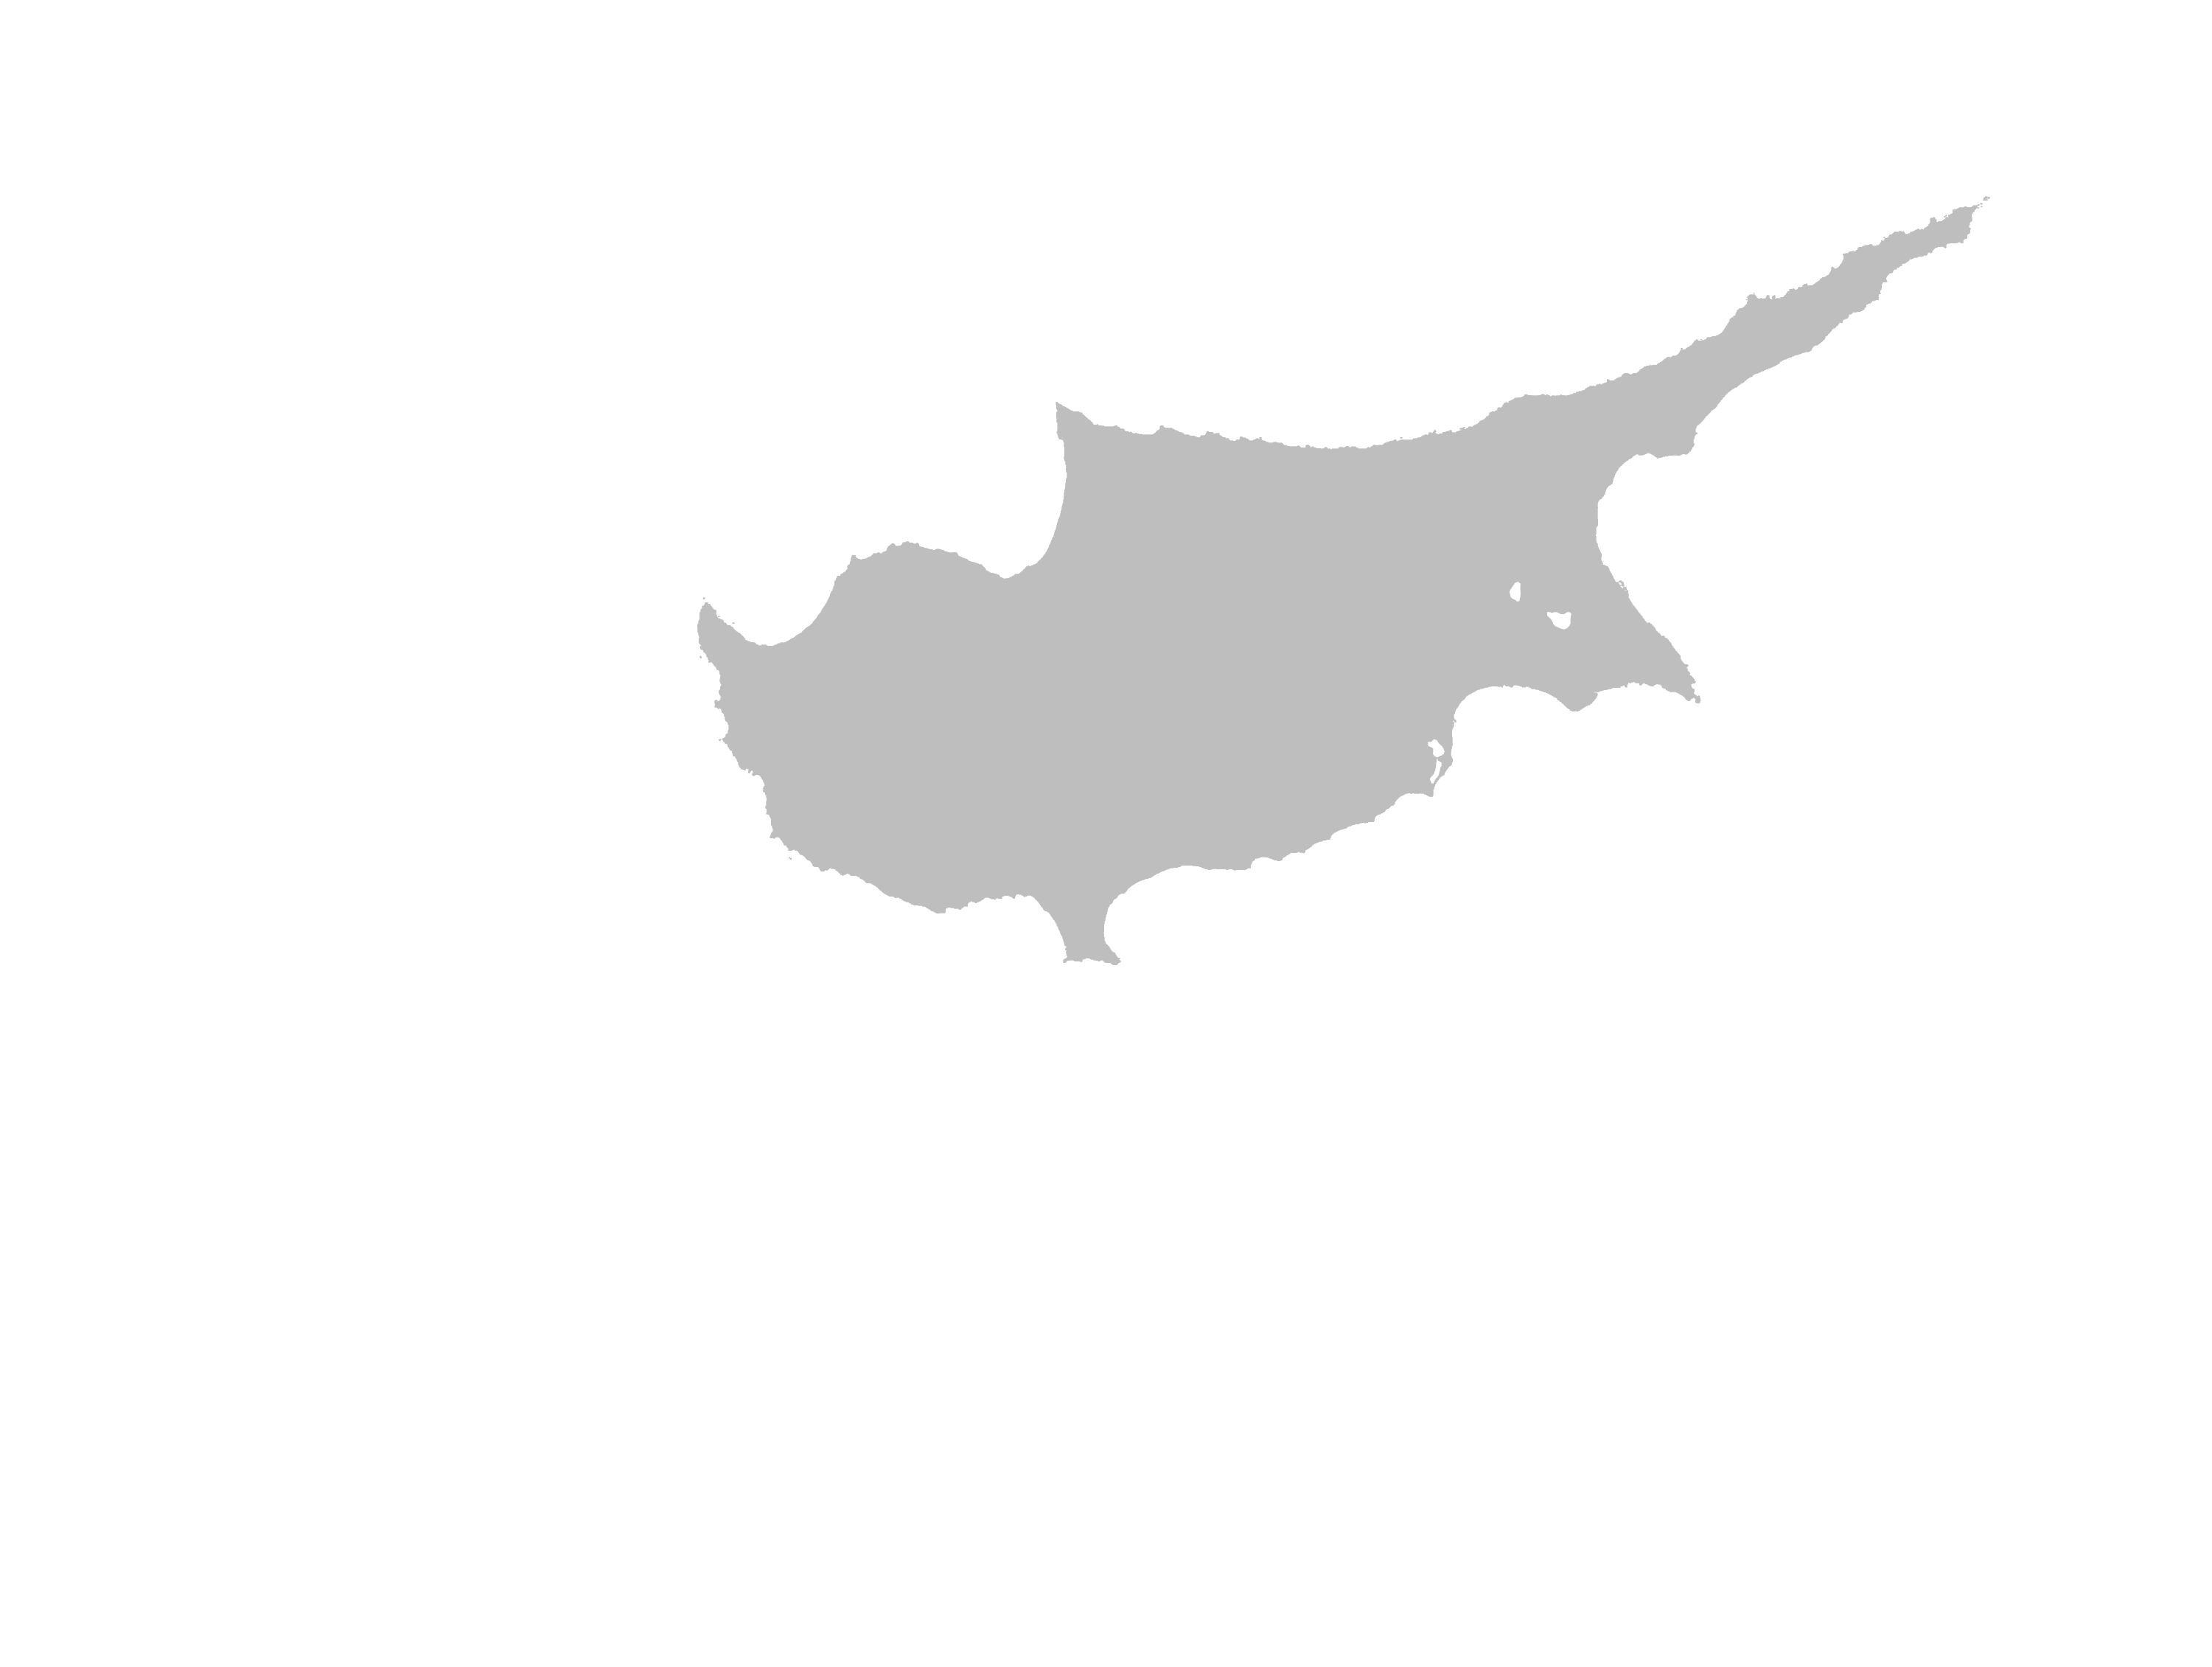

' to do: fix projection according to matlabplot map overlay'

In [4]:
### GMT basemap ###

###########################################
## Specify coords
# llcrnrlat,llcrnrlon, urcrnrlat, urcrnrlon
# are the lat/lon values of the lower left and upper right corners of the map

llcrnrlon=31 # lower left corner lon
llcrnrlat=33.5 # lower left corner lat
urcrnrlon=35.02 # upper right corner lat
urcrnrlat=36 # upper right corner lat

proj_scale_w = 10 # specify projection scale (width)
proj_scale_unit = "i" # choose between c (cm) and i (inches)

grid_freq = 1 # grid frequency (degrees)

###########################################

centerlon = (urcrnrlon - llcrnrlon)/2 + llcrnrlon # midpoints
centerlat = (urcrnrlat - llcrnrlat)/2 + llcrnrlat # should work for all coords


fig = pygmt.Figure() # creating blank figure
fig.coast(region=[llcrnrlon, urcrnrlon, llcrnrlat, urcrnrlat],\
          projection="M%s/%s/%s%s" % (centerlon, urcrnrlat, proj_scale_w, proj_scale_unit),\
          water="white", land="grey", shorelines=False)

          # Mercator
          # can change image size units here
          # M[lon0/lat0] optionally sets central meridian and standard parallel
          # but idk how GMT determines the defaults so i left it in
fig.show()

''' to do: fix projection according to matlabplot map overlay'''

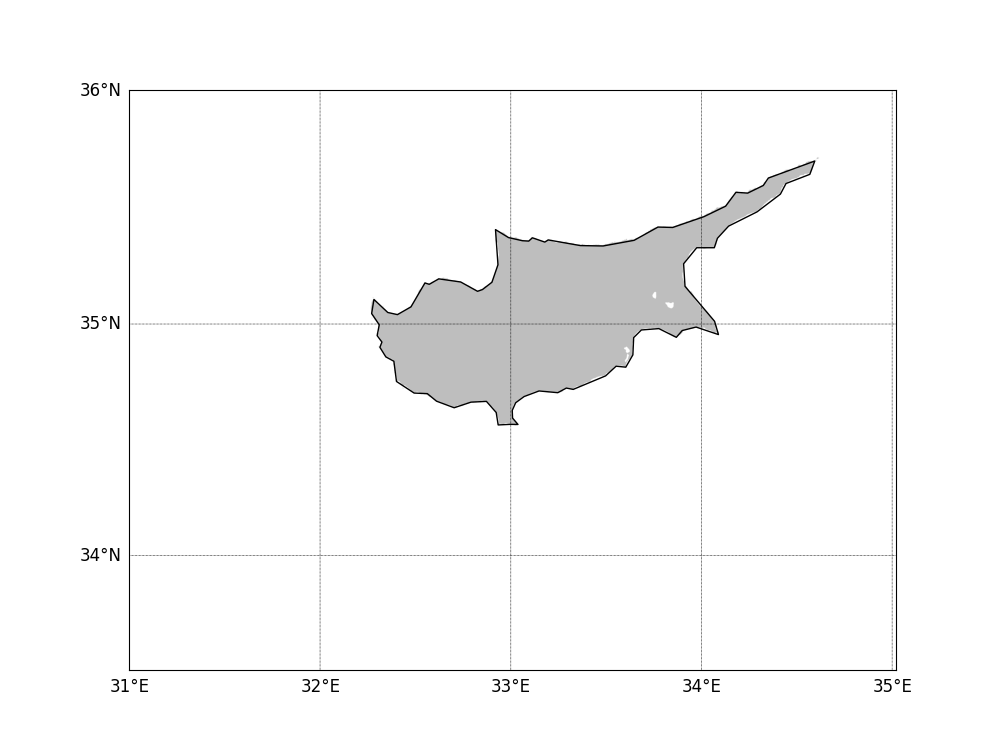

In [5]:
### overlaying matplotlib map for interactive point picking ###
%matplotlib inline
%matplotlib widget


fig.savefig("pygmt_base_map.png") # saving the PyGMT figure as an image

## determining image dimension

img = Image.open("pygmt_base_map.png")
width, height = img.size # (width,height) tuple in pixels
DPI_horz, DPI_vert = img.info.get('dpi')

assert DPI_horz == DPI_vert


# fig, ax = plt.subplots(figsize=(width/DPI_horz, height/DPI_horz)) # inch = pixel/(DPI)
fig = plt.figure(figsize=(width/DPI_horz, height/DPI_horz))
ax1 = plt.subplot(111)

## import pyGMT basemap png
img = mpimg.imread("pygmt_base_map.png")


## creating matplotlib basemap for overlay - https://matplotlib.org/basemap/index.html
m = Basemap(projection='merc', resolution='i',\
                          llcrnrlat=llcrnrlat, urcrnrlat=urcrnrlat,\
                          llcrnrlon=llcrnrlon, urcrnrlon=urcrnrlon)
''' resolution could be even higher (resolution='h' or 'f') but thats not supported on google colab'''

m.drawcoastlines() # draws coastlines on matplotlib. this makes sure that everything is aligned

## plotting parallels and meridians, annotating axis
parallels = np.arange(-90, 90, grid_freq)
meridians = np.arange(-180, 180, grid_freq)
m.drawparallels(parallels, labels=[1,0,0,0], fontsize=12, linewidth=0.5) # label parallels on right and top
m.drawmeridians(meridians, labels=[0,0,0,1], fontsize=12, linewidth=0.5) # meridians on bottom and left

## plotting image in bottom layer - https://stackoverflow.com/questions/11487797/python-matplotlib-basemap-overlay-small-image-on-map-plot
m.imshow(img, origin='upper')

plt.show()


### Interactive point picking ###
# mainly follows this - https://sgcorcoran.github.io/Python-for-MSE/lessons_3114/06_selecting_pixel_coordinates.html
# useful reference - https://matplotlib.org/stable/gallery/event_handling/pick_event_demo.html


## conversion codes - between x y and lon lat
# references this - https://matplotlib.org/basemap/users/mapcoords.html
# lon,lat can be scalars, lists or numpy arrays

def pos_to_lonlat(x, y):
  lon, lat = m(x, y, inverse=True)
  return lon, lat

def lonlat_to_pos(lon, lat):
  x, y = m(lon, lat)
  return x, y

## motified from https://sgcorcoran.github.io/Python-for-MSE/lessons_3114/06_selecting_pixel_coordinates.html
pos = [] # in format [[None, None], [x, y], [x, y], ...]
lonlat = []


def onclick(event):
    pos.append([event.xdata, event.ydata])

    lon, lat = pos_to_lonlat(pos[-1][0], pos[-1][1]) # pos[-1] represent last click (list with x, y)
    lonlat.append([lon, lat]) # converts x y to lon lat and appends

    ax1.set_title(f'Click {len(pos)}: {lon}, {lat}')


cid=fig.canvas.mpl_connect('button_press_event', onclick)